# Supervised Learning: Classifying Chocolate Bars by Rating  
**Laura Chen**  
  
## Table of Contents <a id='top'></a>
[Section 1: Data cleaning and Feature engineering](#section1)  
[Section 2: EDA](#section2)  
[Section 3: Model Selection](#section3)  
[Section 4: Parameter Tuning](#section4)  
[Section 5: Confusion Matrices](#section5)  
[Section 6: Testing the Model](#section6)  
[Appendix](#appendix)

In [4]:
import itertools
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

from sklearn.metrics import mean_squared_error
%matplotlib inline

/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Section 1: Data cleaning and Feature engineering <a id='section1'></a>

# Data Import

In [1281]:
df=pd.read_csv('flavors_of_cacao2.csv',encoding='latin-1')

In [1282]:
# Ended up not using soil data due to losing a lot of data
# http://www.fao.org/faostat/en/#data/QC
# soil_df=pd.read_csv('soildataFAO.csv',encoding='latin-1')

In [1283]:
# Countries of the world: www.statvision.com/webinars/countries%20of%20the%20world.xls
countries_df=pd.read_excel('countries of the world.xls')

In [1284]:
countries_df=countries_df[['Country','Region']]
countries_df['Country']=countries_df['Country'].str.strip()
countries_df['Region']=countries_df['Region'].str.strip()
countries_df['Country']=countries_df['Country'].replace(value='South Korea',regex='(Korea, South)')\
                                            .replace(value='Sao Tome',regex='(Sao Tome & Principe)')

In [1285]:
df.shape

(1852, 9)

# Data Cleaning

**Removing invalid characters and converting values to percentages**

In [1286]:
df.columns=df.columns.str.replace('\n',' ').str.replace('åÊ','')
df['Cocoa Percent']=df['Cocoa Percent'].str.replace("%","").apply(float)
df.loc[df['Cocoa Percent'] > 1, 'Cocoa Percent'] = df['Cocoa Percent']/100

In [1294]:
df.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Johnny Iuzzini,"Costa Esmeralda, Batch 30",2008,2017,0.78,U.S.A.,3.75,NaN,Ecuador
1,Johnny Iuzzini,"Sambirano Valley, Batch 7",2008,2017,0.68,U.S.A.,3.50,NaN,Madagascar
2,INDI,Lam Dong,2008,2017,0.72,U.S.A.,3.25,NaN,Vietnam
3,Ritual,Soconsco,2008,2017,0.75,U.S.A.,3.75,NaN,Mexico
4,Uncouth,Tanzania,2004,2017,0.75,Canada,3.00,NaN,Tanzania


In [1295]:
# Rounding ratings and binning them by tier
df.Rating=df.Rating.apply(round)
df.loc[df['Rating'] == 1, 'Tier'] = '1-Low'
df.loc[df['Rating'] == 2, 'Tier'] = '1-Low'
df.loc[df['Rating'] == 3, 'Tier'] = '2-Med'
df.loc[df['Rating'] == 4, 'Tier'] = '3-High'
df.loc[df['Rating'] == 5, 'Tier'] = '3-High'

In [1296]:
df=df.fillna('Unknown')

**Cleaning up "Bean Type' col**

In [1297]:
# Cleaning up the Bean Types
df['Bean Type']=df['Bean Type'].replace(value='',regex='(\s?\([A-z0-9%,\/\s]+\))')\
                            .replace(value='',regex='(Blend-)')\
                            .replace(value='Forastero ASS',regex='(Forastero ASSS)')

In [1298]:
df['Bean Type2']=df['Bean Type'].str.split(',')
df['First Bean Type']=[x[0].strip() for x in df['Bean Type2']]

In [1299]:
c=[]
def convert(x):
    if len(x)>1:
        c.append(1)
    else:
        c.append(0)

df['Bean Type2'].apply(convert)
df['Blend']=c
df.loc[df['Blend'] == 1, 'Bean Type'] = 'Blend'
df=df.drop(['Blend','Bean Type2'],axis=1)
print(df.shape)

(1852, 11)


**Cleaning up Country Data**  
Replacing abbreviations so the data can match with external country data  
Keeping track of lists of multiple country origins

In [1300]:
df['Company Location']=df['Company Location'].replace(value='Dominican',regex='(Domincan)')\
                                            .replace(value='United States',regex='(U\.S\.A\.)')\
                                            .replace(value='United Kingdom',regex='((U\.K\.)|(Scotland)|(Wales))')\
                                            .replace(value='Ecuador',regex='(Eucador)')\
                                            .replace(value='Netherlands',regex='(Amsterdam)')\
                                            .replace(value='Nicaragua',regex='(Niacragua)')

In [1301]:
df['Broad Bean Origin']=df['Broad Bean Origin']\
        .replace(value='D. R.',regex='(Domin[i]?can Republic)')\
        .replace(value='Dominican Republic',regex='(D(om)?\.?(in)?\.?(ican)?\s?R(ep)?\.?)')\
        .replace(value='Mex',regex='(Mexico)')\
        .replace(value='Ven.,',regex='(Venezuela[\s|/]+)')\
        .replace(value='Ven',regex='(Venezuela)(z)?')\
        .replace(value='Ecu,',regex='(Ecuador\s)')\
        .replace(value='Ecu',regex='(Ecuador)')\
        .replace(value='Mad,',regex='(Madagascar\s)')\
        .replace(value='Mad',regex='(Madagascar)')\
        .replace(value='United States',regex='(Hawaii)')\
        .replace(value='Guat.',regex='Guatemala')\
        .replace(value=',',regex='(\s?&\s?)')\
        .replace(value='Papua New Guinea',regex='PNG')\
        .replace(value='',regex='(\([A-z,\/\s]+\))')\
        .replace(value='Guatemala',regex='Guat\.')\
        .replace(value='Brazil',regex='Brasil')\
        .replace(value='Venezuela',regex='(Ven)\.?(ez)?')\
        .replace(value='Madagascar',regex='(Mad\.?)')\
        .replace(value='Ecuador',regex='(Ecu\.?(ad)?)')\
        .replace(value='Grenada',regex='(Gre\.)')\
        .replace(value='Costa Rica',regex='(Cost Rica)')\
        .replace(value='Dominican Republic,Ecuador,Peru',regex='(Dominican Republic Ecuador Peru)')\
        .replace(value='Venezuela,Dominican Republic',regex='(Venezuela Dominican Republic)')\
        .replace(value='Ecuador,Madagascar',regex='(Ecuador Madagascar)')\
        .replace(value='Madagascar,Ecuador',regex='(MadagascarEcuador)')\
        .replace(value='Mexico',regex='(Mex)')

In [1302]:
df['Broad Bean Origin2']=df['Broad Bean Origin'].str.split(',')
df['First Broad Bean Origin']=[x[0].strip() for x in df['Broad Bean Origin2']]

In [1303]:
c=[]
df['Broad Bean Origin2'].apply(convert)
print(df.shape)

(1852, 13)


In [1304]:
df['Multi_Origin']=c

In [1305]:
df.Multi_Origin.value_counts()

0    1802
1      50
Name: Multi_Origin, dtype: int64

In [1306]:
df.head(3)

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Tier,First Bean Type,Broad Bean Origin2,First Broad Bean Origin,Multi_Origin
0,Johnny Iuzzini,"Costa Esmeralda, Batch 30",2008,2017,0.78,United States,4,Unknown,Ecuador,3-High,Unknown,[Ecuador],Ecuador,0
1,Johnny Iuzzini,"Sambirano Valley, Batch 7",2008,2017,0.68,United States,4,Unknown,Madagascar,3-High,Unknown,[Madagascar],Madagascar,0
2,INDI,Lam Dong,2008,2017,0.72,United States,3,Unknown,Vietnam,2-Med,Unknown,[Vietnam],Vietnam,0


## Additional Feature Engineering

**Joining with additional data**  
**Note:** This part has been removed because adding soil data was causing a lot of rows to drop without significantly improving model performance

In [1307]:
# df3=pd.merge(df2,soil_df[['Country','Value']],left_on='First Broad Bean Origin',right_on='Country',)
# df3.Value.name='Avg % wgt carbon in soil'

**Creating additional dummy variables**

In [1308]:
df2=pd.merge(df,countries_df,left_on='First Broad Bean Origin',right_on='Country')
df2['Origin_Region']=df2.Region.apply(lambda x: 'Origin: '+x)
df2=pd.merge(df2,countries_df,left_on='Company Location',right_on='Country')
df2['Prod_Region']=df2.Region_y.apply(lambda x: 'Prod: '+ x)

In [1309]:
# Creating a column to recognize if a chocolate bar is produced in the same country where the cocoa bean originated
df2['Origin_Prod']=list(zip(df2['Region_x'],df2['Region_y']))

p = []
def local_prod(x):
    if x[0]==x[1]:
        p.append(1)
    else:
        p.append(0)

df2.Origin_Prod.apply(local_prod)
df2['Prod_Locally']=p
df2=df2.drop('Origin_Prod',axis=1)

In [1310]:
df2.drop(['Country_x','Country_y','Region_y','Region_x','Broad Bean Origin2'],axis=1,inplace=True)
df2=pd.concat([df2,pd.get_dummies(df2['First Bean Type']),pd.get_dummies(df2['Origin_Region']),\
                   pd.get_dummies(df2['Company Location'])],axis=1)
df2.head(2)

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin,Tier,...,South Korea,Spain,St. Lucia,Suriname,Sweden,Switzerland,United Kingdom,United States,Venezuela,Vietnam
0,Johnny Iuzzini,"Costa Esmeralda, Batch 30",2008,2017,0.78,United States,4,Unknown,Ecuador,3-High,...,0,0,0,0,0,0,0,1,0,0
1,Brasstown,Manabi,1984,2017,0.75,United States,4,Unknown,Ecuador,3-High,...,0,0,0,0,0,0,0,1,0,0


# Section 2: EDA <a id='section2'></a>  
[Back to Top](#top)

In [1311]:
print(df2.shape)
print(df2.Tier.value_counts())

(1848, 90)
2-Med     927
3-High    730
1-Low     191
Name: Tier, dtype: int64


In [1312]:
print('Accuracy of predicting all Med:',927/1848)

Accuracy of predicting all Med: 0.5016233766233766


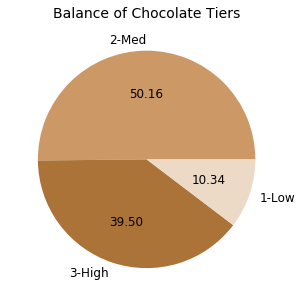

In [1313]:
f=plt.figure(figsize=(5,5))
ax=f.add_subplot(111, aspect='equal')
p=plt.pie(df2.Tier.value_counts(),labels=['2-Med','3-High','1-Low'], colors=['#cc9966','#ac7339','#ecd9c6'],autopct='%.2f',\
          textprops={'fontsize': 12,'color':'black'})
plt.title('Balance of Chocolate Tiers',fontdict={'fontsize': 14})

In [1314]:
df2['Origin_Region'].value_counts()

Origin: LATIN AMER. & CARIB     1330
Origin: SUB-SAHARAN AFRICA       271
Origin: ASIA (EX. NEAR EAST)      77
Origin: Unknown                   74
Origin: OCEANIA                   68
Origin: NORTHERN AMERICA          28
Name: Origin_Region, dtype: int64

In [1315]:
df2=df2.dropna()

## Setting up json for d3 visualization
Commented out this code because it does not need to be run every time. 

In [1316]:
# df2['Company_Location']=df2['Company Location']
# df2.Company_Location=df2.Company_Location.replace('United States','United States of America')

In [1317]:
# json_data=df2.groupby('Company_Location').Rating.mean().sort_values(ascending=False)
# json_data=pd.DataFrame(json_data)
# json_data['Rating_Count']=df2.groupby('Company_Location').Rating.count().sort_values(ascending=False)
# json_data.Rating=json_data.Rating.round(decimals=2)
# json_data=json_data.reset_index()
# json_data.to_json('cocoa2.json',orient='records')

In [1318]:
# json_data.head()

# Section 3: Model Selection <a id='section3'></a>  
Includes experimenting with different models, upsampling, and hyperparameterization.  
[Back to Top](#top)

In [1319]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import cross_val_score

from sklearn import naive_bayes
from sklearn.metrics import accuracy_score, classification_report

## Upsampling

In [1406]:
df2[['Company (Maker-if known)','Cocoa Percent','Rating']].sort_values(by='Cocoa Percent').head(10)

,Company (Maker-if known),Cocoa Percent,Rating
1847,Chokolat Elot (Girard),0.42,3
1776,Luker,0.46,3
1748,AMMA,0.50,4
1781,Santander (Compania Nacional),0.53,2
1755,Kah Kow,0.55,3
1739,Q Chocolate,0.55,3
523,Ethel's Artisan (Mars),0.55,2
583,Ethel's Artisan (Mars),0.55,2
759,Malie Kai (Guittard),0.55,4
760,Guittard,0.55,3


In [1322]:
from sklearn.utils import resample

In [1323]:
y=df2['Tier'].apply(str)
X=df2.drop(['Company (Maker-if known)', 'Specific Bean Origin or Bar Name', 
       'Review Date', 'Company Location', 'Rating','Company_Location',
       'Bean Type', 'Broad Bean Origin','Broad Bean Origin2','First Broad Bean Origin','First Bean Type','REF','Prod_Region','Origin_Region'],axis=1,errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 4444)
X_test=X_test.drop('Tier',axis=1)

In [1324]:
X_train.Tier.value_counts()

2-Med     659
3-High    512
1-Low     122
Name: Tier, dtype: int64

In [1325]:
# Separate majority and minority classes
df_low = X_train[X_train.Tier=='1-Low']
df_med = X_train[X_train.Tier=='2-Med']
df_high = X_train[X_train.Tier=='3-High']

# Upsample minority class
train_upsampled = resample(df_low, 
                         replace=True,     # sample with replacement
                         n_samples=400,    # to match majority class
                         random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
train_upsampled = pd.concat([df_med,df_high ,train_upsampled])
 
# Display new class counts
train_upsampled.Tier.value_counts()

2-Med     659
3-High    512
1-Low     400
Name: Tier, dtype: int64

In [1326]:
X=X.drop('Tier',axis=1,errors='ignore')
y_train=train_upsampled.Tier
X_train=train_upsampled.drop('Tier',axis=1,errors='ignore')

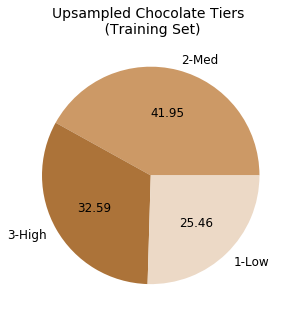

In [1327]:
f=plt.figure(figsize=(5,5))
ax=f.add_subplot(111, aspect='equal')
p=plt.pie(train_upsampled.Tier.value_counts(),labels=['2-Med','3-High','1-Low'],\
          colors=['#cc9966','#ac7339','#ecd9c6'],autopct='%.2f',\
          textprops={'fontsize': 12,'color':'black'})
plt.title('Upsampled Chocolate Tiers \n (Training Set)',fontdict={'fontsize': 14})

## Experimenting with Models

/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/laura

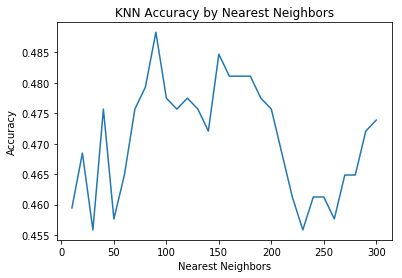

In [1328]:
score = []
nn = []
for i in range(10,301,10):
    knn = KNeighborsClassifier(n_neighbors = i,metric='hamming')
    knn.fit(X_train, y_train)
    score.append(accuracy_score(y_test, knn.predict(X_test)))
    nn.append(i)

plt.plot(nn, score)
plt.title('KNN Accuracy by Nearest Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('Nearest Neighbors');

knn=KNeighborsClassifier(n_neighbors=nn[score.index(max(score))],metric='hamming')
lr = LogisticRegression()
nb = MultinomialNB()
svc = SVC()
rf = RandomForestClassifier()
models=[('KNN',knn),('Logistic Regression',lr),('Multinomial NB',nb),('SVC',svc),('Random Forest',rf)]

model_metrics = {'CV Accuracy':{},
                'CV F1':{}}
for name,model in models:
    model.fit(X_train, y_train)
    model_score = (accuracy_score(y_test, model.predict(X_test)))
    model_acc=np.mean(cross_val_score(model, X, y,cv=5))
    model_f1=np.mean(cross_val_score(model, X, y,scoring='f1_macro',cv=5))
    model_metrics['CV Accuracy'][name]=model_acc
    model_metrics['CV F1'][name]=model_f1



In [1339]:
metrics_df

,Model,CV Accuracy,CV F1
0,KNN,0.496187,0.279136
1,Logistic Regression,0.449593,0.241354
2,Multinomial NB,0.411655,0.269081
3,Random Forest,0.446949,0.298414
4,SVC,0.501623,0.222703


In [1342]:
metrics_df=pd.DataFrame(model_metrics)
metrics_df=metrics_df.reset_index()
metrics_df.rename(index=str, columns={"index": "Model"},inplace=True)
metrics_df[['Model','CV Accuracy']].sort_values(by='CV Accuracy',ascending=False)

,Model,CV Accuracy
4,SVC,0.501623
0,KNN,0.496187
1,Logistic Regression,0.449593
3,Random Forest,0.446949
2,Multinomial NB,0.411655


In [1343]:
metrics_df[['Model','CV F1']].sort_values(by='CV F1',ascending=False)

,Model,CV F1
3,Random Forest,0.298414
0,KNN,0.279136
2,Multinomial NB,0.269081
1,Logistic Regression,0.241354
4,SVC,0.222703


In [1344]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
print("NB Accuracy: %.3f"% accuracy_score(y_test, lr.predict(X_test)))
print("NB CV Score",np.mean(cross_val_score(lr, X, y,cv=10)))
print(classification_report(y_test, lr.predict(X_test)))

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred=rf.predict(X_test)
print("RF Accuracy: %.3f"% accuracy_score(y_test, rf.predict(X_test)))
print("RF CV Score",np.mean(cross_val_score(rf, X, y,cv=10)))
print(classification_report(y_test, rf.predict(X_test)))

svc = SVC()
svc.fit(X_train, y_train)
print("SVC Accuracy: %.3f"% accuracy_score(y_test, svc.predict(X_test)))
print("SVC CV Score",np.mean(cross_val_score(svc, X, y,cv=10)))
print(classification_report(y_test, svc.predict(X_test)))

knn = KNeighborsClassifier(n_neighbors = 7,metric='hamming')
knn.fit(X_train, y_train)
print("KNN Accuracy: %.3f"% accuracy_score(y_test, knn.predict(X_test)))
print("KNN CV Score",np.mean(cross_val_score(knn, X, y,cv=10)))
print(classification_report(y_test, knn.predict(X_test)))

NB Accuracy: 0.431
NB CV Score 0.412300266606
             precision    recall  f1-score   support

      1-Low       0.17      0.16      0.17        69
      2-Med       0.48      0.70      0.57       268
     3-High       0.41      0.18      0.25       218

avg / total       0.41      0.43      0.39       555

RF Accuracy: 0.450
RF CV Score 0.389147429337
             precision    recall  f1-score   support

      1-Low       0.21      0.26      0.23        69
      2-Med       0.50      0.58      0.54       268
     3-High       0.49      0.35      0.41       218

avg / total       0.46      0.45      0.45       555

SVC Accuracy: 0.483
SVC CV Score 0.503246180964
             precision    recall  f1-score   support

      1-Low       0.00      0.00      0.00        69
      2-Med       0.48      1.00      0.65       268
     3-High       0.00      0.00      0.00       218

avg / total       0.23      0.48      0.31       555

KNN Accuracy: 0.467


/Users/laurachen/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


KNN CV Score 0.373389623845
             precision    recall  f1-score   support

      1-Low       0.26      0.20      0.23        69
      2-Med       0.49      0.77      0.60       268
     3-High       0.49      0.17      0.26       218

avg / total       0.46      0.47      0.42       555



# Section 4: Parameter Tuning <a id='section4'></a>
[Back to Top](#top)  
Random Forest was observed to be the best model based on the confusion matrix.  

In [1182]:
X_train.shape

(1571, 77)

In [1183]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
param_dist = {"max_depth": [int(x) for x in np.linspace(100, 110, num = 11)],
              "n_estimators": randint(10,30),
              "max_features": randint(10, 77),
              "min_samples_split": randint(2, 20),
              "min_samples_leaf": randint(2, 20),
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"],
              "class_weight" : ['balanced',None],
              "random_state": [42]}
param_dist['max_depth'].append(None)

In [1346]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, n_iter = 150, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_leaf=8, min_samples_split=12, n_estimators=20, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_leaf=8, min_samples_split=12, n_estimators=20, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_leaf=8, min_samples_split=12, n_estimators=20, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_leaf=8, min_samples_split=12, n_estimators=20, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_leaf=8, min_samples_split=12, n_estimators=20, random_state=42, total=   0.2s
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=110, max_features=70, min_samples_l

[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=27, min_samples_leaf=5, min_samples_split=15, n_estimators=27, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=106, max_features=73, min_samples_leaf=4, min_samples_split=6, n_estimators=28, random_state=42, total=   0.3s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=27, min_samples_leaf=5, min_samples_split=15, n_estimators=27, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=106, max_features=73, min_samples_leaf=4, min_samples_split=6, n_estimators=28, random_state=42, total=   0.4s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=27, min_samples_leaf=5, min_samples_split=15, n_estimators=27, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=27, min_samples_leaf=5, min_samples

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.2s


[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=13, min_samples_leaf=19, min_samples_split=13, n_estimators=11, random_state=42, total=   0.1s
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=13, min_samples_leaf=19, min_samples_split=13, n_estimators=11, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=13, min_samples_leaf=19, min_samples_split=13, n_estimators=11, random_state=42 
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=71, min_samples_leaf=9, min_samples_split=17, n_estimators=22, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=13, min_samples_leaf=19, min_samples_split=13, n_estimators=11, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=71, min_samples_leaf=9,

[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=17, min_samples_leaf=4, min_samples_split=4, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=106, max_features=50, min_samples_leaf=8, min_samples_split=10, n_estimators=17, random_state=42 
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=106, max_features=50, min_samples_leaf=8, min_samples_split=10, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=106, max_features=50, min_samples_leaf=8, min_samples_split=10, n_estimators=17, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=106, max_features=50, min_samples_leaf=8, min_samples_split=10, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=106, max_features=50, min_samples_leaf=8, mi

[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=None, max_features=60, min_samples_leaf=8, min_samples_split=18, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=104, max_features=32, min_samples_leaf=8, min_samples_split=14, n_estimators=24, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=None, max_features=60, min_samples_leaf=8, min_samples_split=18, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=104, max_features=32, min_samples_leaf=8, min_samples_split=14, n_estimators=24, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=104, max_features=32, min_samples_leaf=8, min_samples_split=14, n_estimators=24, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=104, max_features=32, min_samples_leaf=8, min_sam

[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=36, min_samples_leaf=10, min_samples_split=6, n_estimators=10, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=109, max_features=71, min_samples_leaf=2, min_samples_split=2, n_estimators=29, random_state=42, total=   0.4s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=68, min_samples_leaf=10, min_samples_split=18, n_estimators=26, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=36, min_samples_leaf=10, min_samples_split=6, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=68, min_samples_leaf=10, min_samples_split=18, n_estimators=26, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=36, min_samples_leaf=10, min_samples_split=6,

[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=101, max_features=62, min_samples_leaf=13, min_samples_split=7, n_estimators=13, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=26, min_samples_leaf=7, min_samples_split=6, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=26, min_samples_leaf=7, min_samples_split=6, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=26, min_samples_leaf=7, min_samples_split=6, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=26, min_samples_leaf=7, min_samples_split=6, n_estimators=29, random_state=42, total=   0.2s
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=26, min_samp

[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=None, max_features=66, min_samples_leaf=19, min_samples_split=11, n_estimators=12, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=None, max_features=66, min_samples_leaf=19, min_samples_split=11, n_estimators=12, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42 


[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    8.5s


[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=104, max_features=46, min_samples_leaf=10, min_samples_split=10, n_estimators=12, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_samples_split=3, n_estimators=10, random_state=42, total=   0.1s
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=109, max_features=69, min_samples_leaf=18, min_s

[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=17, min_samples_leaf=8, min_samples_split=4, n_estimators=26, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=108, max_features=42, min_samples_leaf=5, min_samples_split=2, n_estimators=23, random_state=42, total=   0.2s
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=17, min_samples_leaf=8, min_samples_split=4, n_estimators=26, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=17, min_samples_leaf=8, min_samples_split=4, n_estimators=26, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=17, min_samples_leaf=8, min_samples_split=4, n_estimators=26, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=107, max_features=17, min_samples_leaf=8, min_samples_split=4, n_estimat

[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=53, min_samples_leaf=15, min_samples_split=7, n_estimators=12, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=55, min_samples_leaf=4, min_samples_split=2, n_estimators=29, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=53, min_samples_leaf=15, min_samples_split=7, n_estimators=12, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=55, min_samples_leaf=4, min_samples_split=2, n_estimators=29, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=53, min_samples_leaf=15, min_samples_split=7, n_estimators=12, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=55, min_sample

[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=106, max_features=51, min_samples_leaf=4, min_samples_split=19, n_estimators=22, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=106, max_features=51, min_samples_leaf=4, min_samples_split=19, n_estimators=22, random_state=42 
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=108, max_features=45, min_samples_leaf=14, min_samples_split=2, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=106, max_features=51, min_samples_leaf=4, min_samples_split=19, n_estimators=22, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=108, max_features=45, min_samples_leaf=14, min_samples_split=2, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=106, max_features=51, min_samples_leaf=4, min_samples_split=19, n_est

[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=56, min_samples_leaf=4, min_samples_split=9, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=56, min_samples_leaf=4, min_samples_split=9, n_estimators=29, random_state=42, total=   0.3s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=56, min_samples_leaf=4, min_samples_split=9, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=56, min_samples_leaf=4, min_samples_split=9, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=None, max_features=39, min_samples_leaf=18, min_samples_split=6, n_estimators=18, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=56, min_samples_leaf=4, min_samples_split=9, 

[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=35, min_samples_leaf=17, min_samples_split=6, n_estimators=23, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=100, max_features=71, min_samples_leaf=6, min_samples_split=13, n_estimators=25, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=35, min_samples_leaf=17, min_samples_split=6, n_estimators=23, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=100, max_features=71, min_samples_leaf=6, min_samples_split=13, n_estimators=25, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=100, max_features=71, min_samples_leaf=6, min_samples_split=13, n_estimators=25, random_state=42, total=   0.3s
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=100, max_features=71, min_samples_leaf

[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=107, max_features=52, min_samples_leaf=13, min_samples_split=14, n_estimators=21, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=100, max_features=70, min_samples_leaf=12, min_samples_split=6, n_estimators=21, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=107, max_features=52, min_samples_leaf=13, min_samples_split=14, n_estimators=21, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=100, max_features=70, min_samples_leaf=12, min_samples_split=6, n_estimators=21, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=107, max_features=52, min_samples_leaf=13, min_samples_split=14, n_estimators=21, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=100, max_features=70, min_samples_leaf=12, min_samples_split=6, n_es

[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=58, min_samples_leaf=4, min_samples_split=17, n_estimators=13, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=58, min_samples_leaf=4, min_samples_split=17, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=58, min_samples_leaf=4, min_samples_split=17, n_estimators=13, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=32, min_samples_leaf=6, min_samples_split=13, n_estimators=26, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=58, min_samples_leaf=4, min_samples_split=17, n_estimators=13, random_state=42, total=   0.1s
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=58, min_samples_leaf=4, min_sa

[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=104, max_features=21, min_samples_leaf=5, min_samples_split=17, n_estimators=16, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=None, max_features=18, min_samples_leaf=8, min_samples_split=15, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=104, max_features=21, min_samples_leaf=5, min_samples_split=17, n_estimators=16, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=104, max_features=21, min_samples_leaf=5, min_samples_split=17, n_estimators=16, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=104, max_features=21, min_samples_leaf=5, min_samples_split=17, n_estimators=16, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=104, max_features=21, min_samples_leaf=5, min_samples_split=17, n_estimators=1

[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   18.2s


[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=100, max_features=16, min_samples_leaf=15, min_samples_split=14, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=110, max_features=27, min_samples_leaf=16, min_samples_split=13, n_estimators=18, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=100, max_features=16, min_samples_leaf=15, min_samples_split=14, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=110, max_features=27, min_samples_leaf=16, min_samples_split=13, n_estimators=18, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=100, max_features=16, min_samples_leaf=15, min_samples_split=14, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=110, max_features=27, min_samples_leaf=16, min_samples

[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=54, min_samples_leaf=14, min_samples_split=19, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=54, min_samples_leaf=14, min_samples_split=19, n_estimators=29, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=54, min_samples_leaf=14, min_samples_split=19, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=108, max_features=48, min_samples_leaf=2, min_samples_split=4, n_estimators=22, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=54, min_samples_leaf=14, min_samples_split=19, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=108, max_features=48, min_samples_leaf=2, mi

[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=33, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=100, max_features=63, min_samples_leaf=4, min_samples_split=17, n_estimators=20, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=33, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=33, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=33, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=107, max_features=33, min_samples_leaf=9, min_samples_split=

[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=42, min_samples_leaf=2, min_samples_split=19, n_estimators=24, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=72, min_samples_leaf=18, min_samples_split=14, n_estimators=10, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=72, min_samples_leaf=18, min_samples_split=14, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=72, min_samples_leaf=18, min_samples_split=14, n_estimators=10, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=72, min_samples_leaf=18, min_samples_split=14, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=72, min_samples_leaf=18

[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=41, min_samples_leaf=3, min_samples_split=9, n_estimators=16, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=41, min_samples_leaf=3, min_samples_split=9, n_estimators=16, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=12, min_samples_leaf=19, min_samples_split=13, n_estimators=10, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=41, min_samples_leaf=3, min_samples_split=9, n_estimators=16, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=entropy, max_depth=105, max_features=12, min_samples_leaf=19, min_samples_split=13, n_estimators=10, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=107, max_features=41, min_samples_leaf=3, min_samples_sp

[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=None, max_features=47, min_samples_leaf=19, min_samples_split=3, n_estimators=27, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=72, min_samples_leaf=3, min_samples_split=7, n_estimators=10, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=None, max_features=47, min_samples_leaf=19, min_samples_split=3, n_estimators=27, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=72, min_samples_leaf=3, min_samples_split=7, n_estimators=10, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=gini, max_depth=102, max_features=72, min_samples_leaf=3, min_samples_split=7, n_estimators=10, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=106, max_features=60, min_samples_leaf=18

[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=102, max_features=76, min_samples_leaf=19, min_samples_split=6, n_estimators=27, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=25, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=102, max_features=76, min_samples_leaf=19, min_samples_split=6, n_estimators=27, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=25, min_samples_leaf=9, min_samples_split=5, n_estimators=17, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=102, max_features=76, min_samples_leaf=19, min_samples_split=6, n_estimators=27, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=102, max_features=76, min_samples_leaf=19, min_samples_split=6, n_estimat

[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=11, min_samples_leaf=14, min_samples_split=15, n_estimators=28, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=61, min_samples_leaf=16, min_samples_split=16, n_estimators=23, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=11, min_samples_leaf=14, min_samples_split=15, n_estimators=28, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=11, min_samples_leaf=14, min_samples_split=15, n_estimators=28, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=11, min_samples_leaf=14, min_samples_split=15, n_estimators=28, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=61, min_samples_leaf=16, min_samples_split=16, n_estim

[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=27, min_samples_leaf=16, min_samples_split=5, n_estimators=24, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=27, min_samples_leaf=16, min_samples_split=5, n_estimators=24, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=49, min_samples_leaf=18, min_samples_split=13, n_estimators=28, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=27, min_samples_leaf=16, min_samples_split=5, n_estimators=24, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=107, max_features=49, min_samples_leaf=18, min_samples_split=13, n_estimators=28, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=27, min_samples_leaf=16, min_samples_split=5, n_e

[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=103, max_features=33, min_samples_leaf=7, min_samples_split=3, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=103, max_features=33, min_samples_leaf=7, min_samples_split=3, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=103, max_features=33, min_samples_leaf=7, min_samples_split=3, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=103, max_features=33, min_samples_leaf=7, min_samples_split=3, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=105, max_features=60, min_samples_leaf=3, min_samples_split=16, n_estimators=20, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=103, max_features=33, min_samples_leaf=7, min_samples_split=3, n_estimators=29,

[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=110, max_features=12, min_samples_leaf=2, min_samples_split=7, n_estimators=27, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=106, max_features=19, min_samples_leaf=13, min_samples_split=3, n_estimators=22, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=106, max_features=19, min_samples_leaf=13, min_samples_split=3, n_estimators=22, random_state=42, total=   0.1s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=106, max_features=19, min_samples_leaf=13, min_samples_split=3, n_estimators=22, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=gini, max_depth=110, max_features=12, min_samples_leaf=2, min_samples_split=7, n_estimators=27, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=None, criterion=gini, max_depth=106, max_features=19, min_samples_leaf=13, min_samples_split=3, n

[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=46, min_samples_leaf=6, min_samples_split=15, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=105, max_features=69, min_samples_leaf=9, min_samples_split=12, n_estimators=18, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=46, min_samples_leaf=6, min_samples_split=15, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=105, max_features=69, min_samples_leaf=9, min_samples_split=12, n_estimators=18, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=46, min_samples_leaf=6, min_samples_split=15, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=102, max_features=46, min_samples_leaf=6, min_samples_spl

[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   31.9s


[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=106, max_features=75, min_samples_leaf=15, min_samples_split=9, n_estimators=17, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=105, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=28, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=105, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=28, random_state=42, total=   0.1s
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=105, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=28, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=gini, max_depth=105, max_features=15, min_samples_leaf=4, min_samples_split=8, n_estimators=28, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=105, max_features=15, min_samples_leaf=4, min_sa

[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, max_features=54, min_samples_leaf=3, min_samples_split=5, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=61, min_samples_leaf=16, min_samples_split=9, n_estimators=14, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, max_features=54, min_samples_leaf=3, min_samples_split=5, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=entropy, max_depth=103, max_features=61, min_samples_leaf=16, min_samples_split=9, n_estimators=14, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, max_features=54, min_samples_leaf=3, min_samples_split=5, n_estimators=13, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=None, max_features=54, min_samples_leaf=3, min_sa

[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=104, max_features=46, min_samples_leaf=9, min_samples_split=11, n_estimators=26, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=108, max_features=60, min_samples_leaf=15, min_samples_split=9, n_estimators=18, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=104, max_features=46, min_samples_leaf=9, min_samples_split=11, n_estimators=26, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=108, max_features=60, min_samples_leaf=15, min_samples_split=9, n_estimators=18, random_state=42 
[CV]  bootstrap=False, class_weight=None, criterion=entropy, max_depth=104, max_features=46, min_samples_leaf=9, min_samples_split=11, n_estimators=26, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=108, max_features=60, min_samples

[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=105, max_features=11, min_samples_leaf=8, min_samples_split=19, n_estimators=11, random_state=42, total=   0.1s
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=105, max_features=11, min_samples_leaf=8, min_samples_split=19, n_estimators=11, random_state=42 
[CV] bootstrap=True, class_weight=None, criterion=gini, max_depth=105, max_features=11, min_samples_leaf=8, min_samples_split=19, n_estimators=11, random_state=42 
[CV]  bootstrap=True, class_weight=balanced, criterion=gini, max_depth=109, max_features=61, min_samples_leaf=10, min_samples_split=4, n_estimators=29, random_state=42, total=   0.2s
[CV] bootstrap=True, class_weight=balanced, criterion=entropy, max_depth=110, max_features=68, min_samples_leaf=13, min_samples_split=8, n_estimators=29, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=105, max_features=11, min_samples_leaf=8, min_samples_split=19, n_estima

[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=106, max_features=60, min_samples_leaf=18, min_samples_split=14, n_estimators=25, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=56, min_samples_leaf=19, min_samples_split=3, n_estimators=26, random_state=42 
[CV]  bootstrap=True, class_weight=None, criterion=gini, max_depth=106, max_features=60, min_samples_leaf=18, min_samples_split=14, n_estimators=25, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=56, min_samples_leaf=19, min_samples_split=3, n_estimators=26, random_state=42 
[CV]  bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=56, min_samples_leaf=19, min_samples_split=3, n_estimators=26, random_state=42, total=   0.2s
[CV] bootstrap=False, class_weight=balanced, criterion=entropy, max_depth=100, max_features=56, min_samples_l

[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:   37.6s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=150, n_jobs=-1,
          param_distributions={'max_depth': [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, None], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2df2fcf8>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a2df56cf8>, 'min_samples_split': <scipy.sta... False], 'criterion': ['gini', 'entropy'], 'class_weight': ['balanced', None], 'random_state': [42]},
          pre_dispatch='2*n_jobs', ra

In [1347]:
rf_random.best_params_

{'bootstrap': False,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 108,
 'max_features': 48,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 22,
 'random_state': 42}

{'bootstrap': False,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 107,
 'max_features': 41,
 'min_samples_leaf': 3,
 'min_samples_split': 9,
 'n_estimators': 16,
 'random_state': 42}

In [1348]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy=accuracy_score(test_labels,predictions)
    print('Model Performance')
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy
base_model = RandomForestClassifier(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Accuracy = 0.43%.
Model Performance
Accuracy = 0.46%.
Improvement of 6.22%.


In [1351]:
best_random = rf_random.best_estimator_
best_random.fit(X_train,y_train)
print("RF Accuracy: %.3f"% accuracy_score(y_test, best_random.predict(X_test)))
print("RF CV Score",np.mean(cross_val_score(best_random, X, y,cv=10)))
print(classification_report(y_test, best_random.predict(X_test)))

RF Accuracy: 0.461
RF CV Score 0.402628880634
             precision    recall  f1-score   support

      1-Low       0.22      0.26      0.24        69
      2-Med       0.50      0.57      0.54       268
     3-High       0.50      0.39      0.44       218

avg / total       0.47      0.46      0.46       555



**Investigating feature importance**

In [1385]:
features=sorted(zip(X.columns,rf.feature_importances_),key = lambda t: t[1],reverse=True)
features[:5]

[('Cocoa Percent', 0.45219231920767483),
 ('United States', 0.031806747444793122),
 ('Origin: LATIN AMER. & CARIB', 0.029333040955395462),
 ('Unknown', 0.028751917334252031),
 ('Trinitario', 0.024050715695705823)]

In [847]:
import json
from sklearn.preprocessing import scale

**Looking at feature importances specific to a class**

In [1387]:
def class_feature_importance(X, Y, feature_importances):
    N, M = X.shape
    X = scale(X)

    out = {}
    for c in set(Y):
        out[c] = dict(
            zip(range(N), np.mean(X[Y==c, :], axis=0)*feature_importances)
        )

    return out

In [1408]:
feature_importances=best_random.feature_importances_
result = class_feature_importance(X, y, feature_importances)

In [1422]:
result

{'1-Low': {0: 0.11865724682929329,
  1: -0.00046326019644492349,
  2: 0.0012257796039361814,
  3: -0.0,
  4: -8.2943566675514912e-05,
  5: -6.7864853626262273e-05,
  6: -0.00017612654967612835,
  7: -0.0,
  8: -0.0024003797683852914,
  9: -5.4236810251503309e-06,
  10: 0.0049864069518008166,
  11: 0.00050141436297345169,
  12: -3.3287814505206969e-05,
  13: 0.0,
  14: -0.0058907772381709186,
  15: 0.0048688554471427899,
  16: -0.0014655893327271778,
  17: 0.0012334636489209664,
  18: 1.6235406267972609e-05,
  19: -0.0015327823018758248,
  20: -0.0024889887171762521,
  21: 0.0069162681802279391,
  22: -5.1175971542696876e-05,
  23: -0.0010485383797378507,
  24: -0.0011336060302973815,
  25: 0.0013555337611559782,
  26: -0.0,
  27: -0.00025194807133939765,
  28: -0.00371693391588473,
  29: -0.0,
  30: -0.00022972827793718342,
  31: 5.2587406243052678e-07,
  32: -0.0,
  33: -0.0002676912898068934,
  34: -7.3247730180588579e-07,
  35: 0.0030764924587829041,
  36: -0.0,
  37: -0.0,
  38: -0

These features are most important for predicting a High rating

In [1409]:
feat=sorted(zip(X.columns,list(result['3-High'].values())),key = lambda t: t[1],reverse=True)
feat[:15]

[('Criollo', 0.0020254303055195397),
 ('France', 0.0017105482505599765),
 ('Trinitario', 0.0011584996492433697),
 ('Canada', 0.0011091468827678702),
 ('Blend', 0.0010015247253089997),
 ('Australia', 0.00091740062706588312),
 ('Italy', 0.00086484602163501795),
 ('Origin: SUB-SAHARAN AFRICA', 0.00075309113915634314),
 ('Belgium', 0.00060811821775863593),
 ('Origin: ASIA (EX. NEAR EAST)', 0.00046447560060538129),
 ('Multi_Origin', 0.00033722886228748313),
 ('Switzerland', 0.00032317658323789878),
 ('Origin: OCEANIA', 0.00031247308377768625),
 ('Vietnam', 0.00022319053465267368),
 ('Austria', 0.00014183016086824428)]

# Section 5: Confusion Matrices<a id='section5'></a>
[Back to Top](#top)  

In [62]:
from sklearn.metrics import confusion_matrix

In [287]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.2   0.75  0.04]
 [ 0.09  0.77  0.13]
 [ 0.06  0.76  0.17]]
Normalized confusion matrix
[[ 0.19  0.71  0.1 ]
 [ 0.13  0.69  0.18]
 [ 0.14  0.69  0.17]]
Normalized confusion matrix
[[ 0.16  0.71  0.13]
 [ 0.12  0.7   0.18]
 [ 0.1   0.72  0.18]]
Normalized confusion matrix
[[ 0.26  0.65  0.09]
 [ 0.15  0.64  0.21]
 [ 0.14  0.57  0.29]]
Normalized confusion matrix
[[ 0.26  0.62  0.12]
 [ 0.15  0.58  0.26]
 [ 0.13  0.52  0.35]]
Normalized confusion matrix
[[ 0.26  0.64  0.1 ]
 [ 0.14  0.57  0.28]
 [ 0.12  0.49  0.39]]


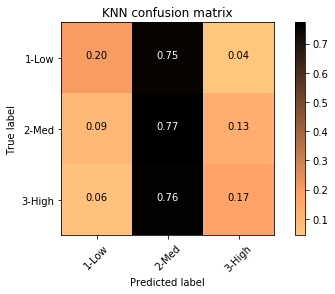

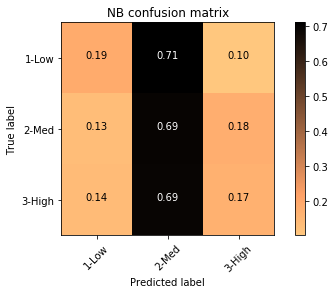

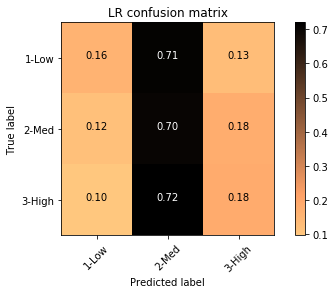

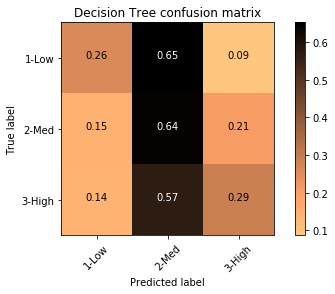

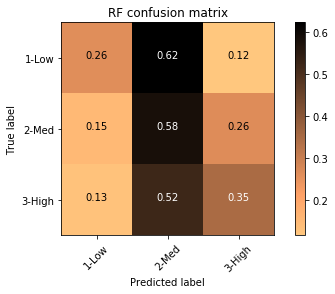

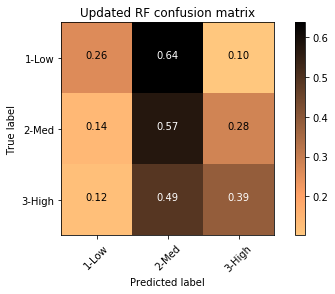

In [1352]:
#Plot a confusion matrix for each model

models=[('KNN',knn),('NB',nb),('LR',lr),('Decision Tree',dtc),('RF',rf),('Updated RF', best_random)]
for name,model in models:
    y_pred=model.predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='%s confusion matrix'%name)


# Section 6: Testing the Model<a id='section6'></a>
[Back to Top](#top)  

In [946]:
X.columns.shape

(77,)

In [1423]:
# Use this to find the index number of a specific feature
columns=list(X.columns)
columns.index('Criollo')

8

In [1420]:
# Set up some fake test data
zero_arr=np.zeros((1,77))
zero_arr[0][0]=0. #Cocoa pct
zero_arr[0][1]=0 # Multi_orig
zero_arr[0][8]=1 # Criollo
zero_arr[0][14]=1 # feat
zero_arr[0][6]=0 # Blend
zero_arr[0][57]=1 # France
zero_arr[0][39]=1 # Origin: SUB-SAHARAN AFRICA

prob_high=[]
for i in np.linspace(0,1,10):
    zero_arr[0][0]=i
    best_random.predict(zero_arr)
    p=best_random.predict_proba(zero_arr)[0][2]
    prob_high.append(p)

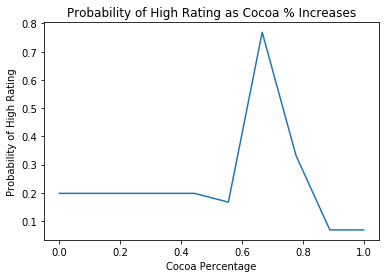

In [1421]:
plt.plot(np.linspace(0,1,10),prob_high)
plt.title('Probability of High Rating as Cocoa % Increases')
plt.xlabel('Cocoa Percentage')
plt.ylabel('Probability of High Rating')

In [1402]:
# Predicting on Lindt chocolate
zero_arr=np.zeros((1,77))
zero_arr[0][0]=.3 #Cocoa pct
zero_arr[0][1]=1 # Multi Origin
zero_arr[0][6]=1 # Cocoa Bean Blend 
zero_arr[0][17]=1 # Origin: LATIN AMER. & CARIB
zero_arr[0][74]=1 # Produced in United States
zero_arr[0][15]=1 # Unknown/undisclosed beans

# prob_high=[]
# for i in np.linspace(0,1,10):
#     zero_arr[0][0]=i
#     best_random.predict(zero_arr)
#     p=best_random.predict_proba(zero_arr)[0][2]
#     prob_high.append(p)

In [1403]:
best_random.predict(zero_arr)

array(['1-Low'], dtype=object)

In [1404]:
predprobs=['%.2f'%x for x in list(best_random.predict_proba(zero_arr)[0])]

list(zip(['1-Low','2-Med','3-High'],predprobs))

[('1-Low', '0.55'), ('2-Med', '0.32'), ('3-High', '0.14')]

# Appendix <a id='appendix'></a>
  
Model performs very well if you include categories on brands, but we cannot get a lot of detail about 
Confusion Matrix or ROC Curves.  
[Back to Top](#top)

## Experimenting with Polynomial Features
**Note:** Polynomial features provided very similar model performance while significantly increasing complexity. Thus, they were not used in the final model.

In [80]:
from sklearn.preprocessing import PolynomialFeatures

In [492]:
# y=df2['Tier'].apply(str)
# X=df2.drop(['Company (Maker-if known)', 'Specific Bean Origin or Bar Name', 
#        'Review Date', 'Company Location', 'Rating',
#        'Bean Type', 'Broad Bean Origin','Broad Bean Origin2','First Broad Bean Origin','First Bean Type','REF','Prod_Region','Origin_Region'],axis=1,errors='ignore')

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 4444)
# X_test=X_test.drop('Tier',axis=1)

In [493]:
# # Separate majority and minority classes
# df_low = X_train[X_train.Tier=='1-Low']
# df_med = X_train[X_train.Tier=='2-Med']
# df_high = X_train[X_train.Tier=='3-High']

# # Upsample minority class
# train_upsampled = resample(df_low, 
#                          replace=True,
#                          n_samples=300,
#                          random_state=123)
 
# # Combine majority class with upsampled minority class
# train_upsampled = pd.concat([df_med,df_high ,train_upsampled])
 
# # Display new class counts
# train_upsampled.Tier.value_counts()

2-Med     659
3-High    512
1-Low     300
Name: Tier, dtype: int64

In [494]:
# poly = PolynomialFeatures(interaction_only=True)
# X_train=train_upsampled.drop('Tier',axis=1)
# y_train=train_upsampled.Tier
# X_train=poly.fit_transform(X_train)
# X_test=poaly.transform(X_test)

In [495]:
# X=X.drop('Tier',axis=1)
# X=poly.transform(X)

In [2646]:
# nb = MultinomialNB()
# nb.fit(X_train, y_train)
# print("NB Accuracy: %.3f"% accuracy_score(y_test, nb.predict(X_test)))
# print("NB CV Score",np.mean(cross_val_score(nb, X, y,cv=10)))
# print(classification_report(y_test, nb.predict(X_test)))

NB Accuracy: 0.393
NB CV Score 0.362316344475
             precision    recall  f1-score   support

       High       0.42      0.29      0.35       214
        Low       0.37      0.29      0.33       207
        Med       0.39      0.55      0.46       271

avg / total       0.39      0.39      0.38       692



In [94]:
# rf = RandomForestClassifier()
# rf.fit(X_train, y_train)
# print("RF Accuracy: %.3f"% accuracy_score(y_test, rf.predict(X_test)))
# print("RF CV Score",np.mean(cross_val_score(rf, X, y,cv=10)))
# print(classification_report(y_test, rf.predict(X_test)))

RF Accuracy: 0.467
RF CV Score 0.390222698154
             precision    recall  f1-score   support

      1-Low       0.32      0.26      0.29        69
      2-Med       0.49      0.61      0.54       268
     3-High       0.48      0.36      0.41       218

avg / total       0.46      0.47      0.46       555



In [2813]:
# features=sorted(zip(poly.get_feature_names([x for x in X.columns]),rf.feature_importances_),\
#                 key = lambda t: t[1],reverse=True)